- https://albertauyeung.github.io/2017/04/23/python-matrix-factorization.html

# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import boxcox, inv_boxcox
from scipy import stats
from PIL import Image

from fastai.tabular.all import *
from fastai.collab import *

# Entregable Intelia

In [8]:
class RecSys():

    def __init__(self, df_pairs, df_users=None, df_items=None, varUser="customer_id", varItem="product_id", varScore="peso"):
        
        # Save user-item pairs dataframe
        self.df_pairs = df_pairs
        self.df_users = df_users
        self.df_items = df_items
        
        # if df_users
        # Comprobar que los df_pairs.user_id esten en df_users.id
        
        # if df_items
        # Comprobar que los df_pairs.item_id esten en df_items.id
        
        matrix_users  = df_pairs[varUser].values
        matrix_items  = df_pairs[varItem].values
        matrix_scores = df_pairs[varScore].values
        
        user_ids, matrix_users2 =  np.unique( matrix_users, return_inverse=True)
        item_ids, matrix_items2 =  np.unique( matrix_items, return_inverse=True)

        self.num_users = len(user_ids)
        self.num_items = len(item_ids)
        
        # Sparse matrix: List of tuples [(user,item,score), (user,item,score), ...]
        self.samples = list(zip(matrix_users2, matrix_items2, matrix_scores))
        self.b       = matrix_scores.mean()


    def train(self, embSize, lr, wd, epochs, train_perc=1):
        """
        Perform matrix factorization to predict empty entries in a matrix.

        Arguments
        - embSize (int)    : number of latent dimensions
        - lr (float)       : learning rate
        - wd (float)       : regularization parameter
        """
        
        # Initialize user and item embeddings
        self.emb_u = np.random.normal(scale=1./embSize, size=(self.num_users, embSize))
        self.emb_i = np.random.normal(scale=1./embSize, size=(self.num_items, embSize))

        # Initialize user and item biases
        self.b_u = np.zeros(self.num_users)
        self.b_i = np.zeros(self.num_items)

        # Separate training and validation samples
        split_idx = int(len(self.samples) * train_perc)
        np.random.shuffle(self.samples)
        self.train_samples = self.samples[:split_idx]
        self.valid_samples = self.samples[split_idx:]

        # Perform stochastic gradient descent for number of epochs
        training_process = {"epoch": [], "train_mae": [], "valid_mae": [], "train_mse": [], "valid_mse": []}
        for i in range(epochs):
            self.sgd_epoch(lr, wd)
            train_mae, train_mse, valid_mae, valid_mse = self.errors()
            training_process["epoch"].append(i+1)
            training_process["train_mae"].append(train_mae)
            training_process["valid_mae"].append(valid_mae)
            training_process["train_mse"].append(train_mse)
            training_process["valid_mse"].append(valid_mse)
            print("Epoch: %d ; trMAE = %.4f trMSE = %.4f valMAE = %.4f valMSE = %.4f" % (i+1, train_mae, train_mse, valid_mae, valid_mse))

        self.plot_training(training_process)
    
    
    def plot_training(self, training_process):
        self.plot_metric(training_process, metric="mae", title="Mean Absolute Error")
        self.plot_metric(training_process, metric="mse", title="Mean Square Error")

        
    def plot_metric(self, training_process, metric, title):
        plt.figure(figsize=((16,4)))
        plt.tick_params(labelright=True)
        plt.plot(training_process["epoch"], training_process["train_"+metric])
        plt.plot(training_process["epoch"], training_process["valid_"+metric], linewidth=3)
        plt.xticks(training_process["epoch"], training_process["epoch"])
        plt.xlabel("Epoch")
        #plt.ylabel(metric)
        plt.title(title)
        plt.grid(axis="y")
        plt.show()
    


    def sgd_epoch(self, lr, wd):
        """
        Perform stochastic graident descent epoch
        """
        np.random.shuffle(self.train_samples)
        for user, item, groudTruth in self.train_samples:

            # Computer prediction and error
            prediction = self.get_score(user, item)
            err = (groudTruth - prediction)

            # Update biases
            self.b_u[user] += lr * (err - wd * self.b_u[user])
            self.b_i[item] += lr * (err - wd * self.b_i[item])

            # Update user and item embeddings
            self.emb_u[user, :] += lr * (err * self.emb_i[item, :] - wd * self.emb_u[user,:])
            self.emb_i[item, :] += lr * (err * self.emb_u[user, :] - wd * self.emb_i[item,:])


    def errors(self):
        """
        A function to compute the errors
        """
        predicted = self.full_matrix()
        
        train_mae = 0
        train_mse = 0
        for x, y, real in self.train_samples:
            diference = real - predicted[x, y]
            train_mae += abs(diference)
            train_mse += pow(diference, 2)
        train_mae /= len(self.train_samples)
        train_mse /= len(self.train_samples)

        valid_mae = 0
        valid_mse = 0
        for x, y, real in self.valid_samples:
            diference = real - predicted[x, y]
            valid_mae += abs(diference)
            valid_mse += pow(diference, 2)  
        valid_mae /= len(self.valid_samples)
        valid_mse /= len(self.valid_samples)
        
        return train_mae, train_mse, valid_mae, valid_mse
        

    def get_score(self, u, i):
        """
        Get the predicted score of user u and item i
        """
        return self.b + self.b_u[u] + self.b_i[i] + self.emb_u[u, :].dot(self.emb_i[i, :].T)

    def full_matrix(self):
        """
        Compute the full matrix: Matrix product of embedding, plus broadcasting biases.
        """
        return self.b + self.b_u[:,np.newaxis] + self.b_i + (self.emb_u @ self.emb_i.T)
    
    def draw_matrix(self, margin=True):
        
        print("Number of users:", self.num_users)
        print("Number of items:", self.num_items)
        print("Number of interactions:", len(self.samples))
                          
        if margin and (self.df_users is not None) and (self.df_items is not None):
            matrix = np.full( shape=(len(self.df_users), len(self.df_users)), fill_value=127, dtype=np.uint8 )
            matrix[:self.num_users, :self.num_items] = 0
        else:
            matrix = np.full( shape=(self.num_users, self.num_items), fill_value=0, dtype=np.uint8 )
            
        for user_idx, item_idx, score in self.samples:
            matrix[user_idx, item_idx] = 255
    
        display(Image.fromarray(matrix))


# <center> Datos Fastai (MovieLens 100K)

In [3]:
path = untar_data(URLs.ML_100k)
df_fastai = pd.read_csv(path/'u.data', delimiter='\t', header=None, usecols=(0,1,2), names=['user','movie','rating'])
df_fastai.head()

,user,movie,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


In [9]:
movielens = RecSys(df_fastai, varUser="user", varItem="movie", varScore="rating")

Number of users: 943
Number of items: 1682
Number of interactions: 100000


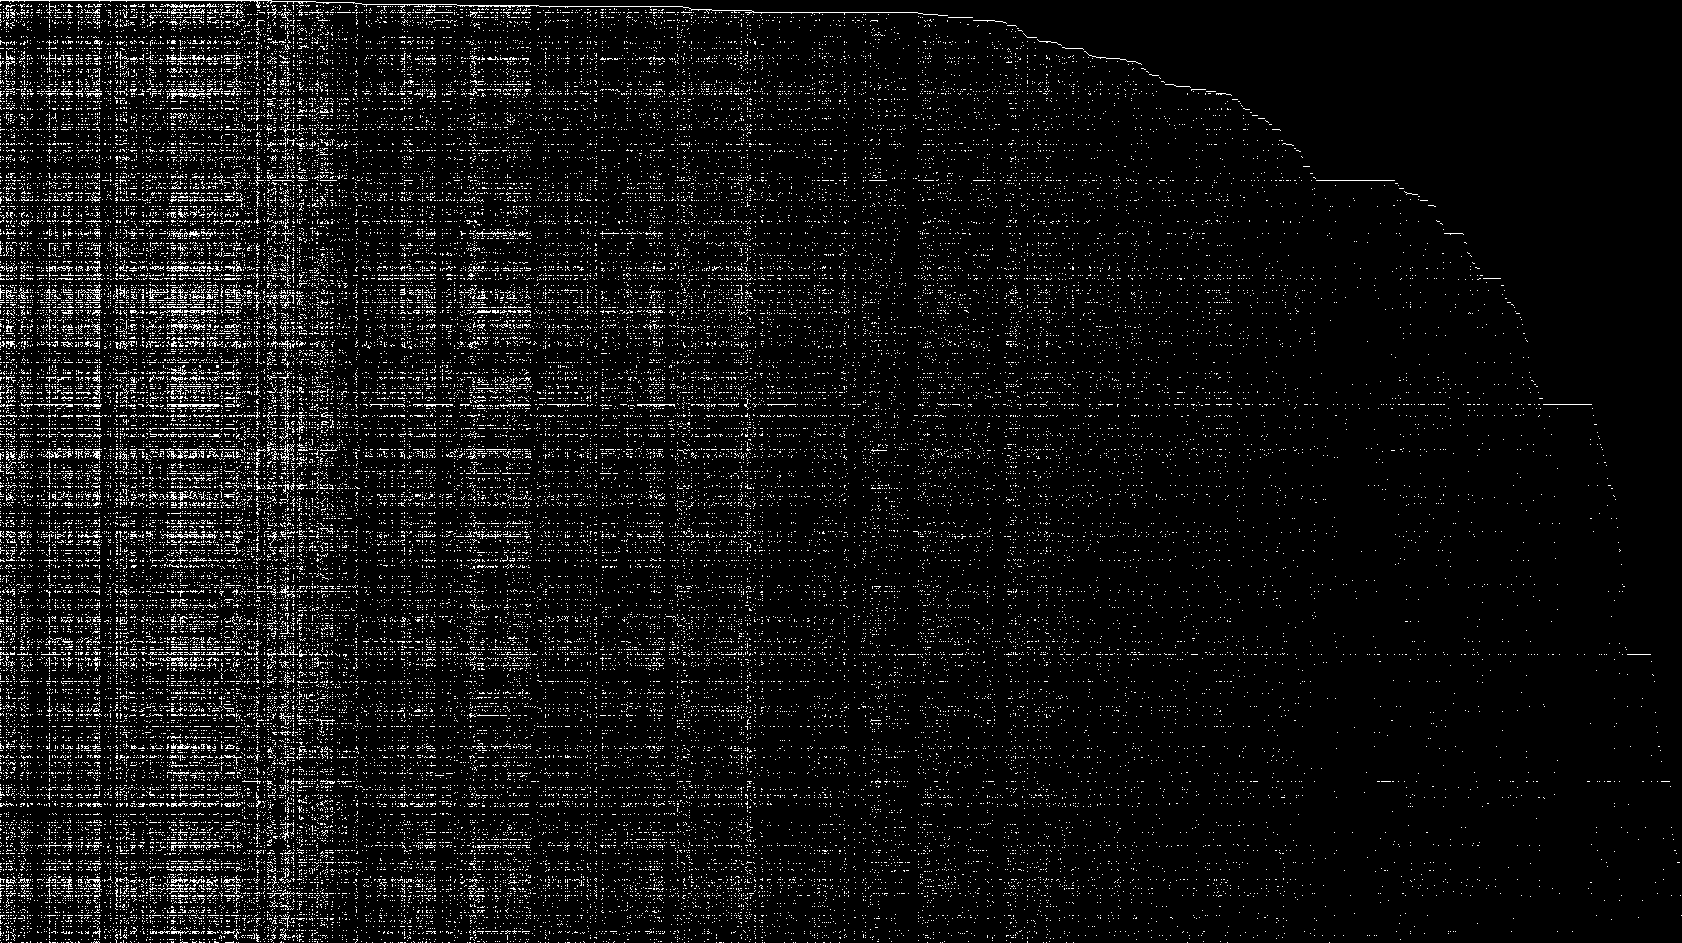

In [5]:
movielens.draw_matrix()

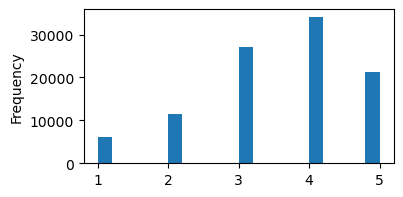

In [6]:
df_fastai.rating.plot.hist(bins=20, figsize=(4,2));

## Train with fast.ai

In [7]:
dls = CollabDataLoaders.from_df(ratings=df_fastai,
                                valid_pct=0.2,
                                user_name="user",
                                item_name="movie",
                                rating_name="rating",
                                seed=None,
                                bs=64)

learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5), metrics=[mae])
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,mae,time
0,0.956625,0.944970,0.775286,00:04
1,0.848733,0.873079,0.743484,00:04
2,0.730015,0.830924,0.722999,00:04
3,0.594013,0.816538,0.716112,00:04
4,0.497935,0.816480,0.715942,00:04


## Train with my module

Epoch: 1 ; trMAE = 0.7753 trMSE = 0.9368 valMAE = 0.7836 valMSE = 0.9622
Epoch: 2 ; trMAE = 0.7535 trMSE = 0.8934 valMAE = 0.7649 valMSE = 0.9264
Epoch: 3 ; trMAE = 0.7436 trMSE = 0.8741 valMAE = 0.7568 valMSE = 0.9108
Epoch: 4 ; trMAE = 0.7385 trMSE = 0.8633 valMAE = 0.7523 valMSE = 0.9019
Epoch: 5 ; trMAE = 0.7350 trMSE = 0.8567 valMAE = 0.7505 valMSE = 0.8985
Epoch: 6 ; trMAE = 0.7332 trMSE = 0.8525 valMAE = 0.7494 valMSE = 0.8958
Epoch: 7 ; trMAE = 0.7315 trMSE = 0.8490 valMAE = 0.7480 valMSE = 0.8926
Epoch: 8 ; trMAE = 0.7310 trMSE = 0.8470 valMAE = 0.7481 valMSE = 0.8927
Epoch: 9 ; trMAE = 0.7296 trMSE = 0.8444 valMAE = 0.7470 valMSE = 0.8905
Epoch: 10 ; trMAE = 0.7285 trMSE = 0.8428 valMAE = 0.7463 valMSE = 0.8895
Epoch: 11 ; trMAE = 0.7273 trMSE = 0.8408 valMAE = 0.7455 valMSE = 0.8882
Epoch: 12 ; trMAE = 0.7270 trMSE = 0.8391 valMAE = 0.7454 valMSE = 0.8871
Epoch: 13 ; trMAE = 0.7263 trMSE = 0.8379 valMAE = 0.7450 valMSE = 0.8871
Epoch: 14 ; trMAE = 0.7252 trMSE = 0.8360 valMA

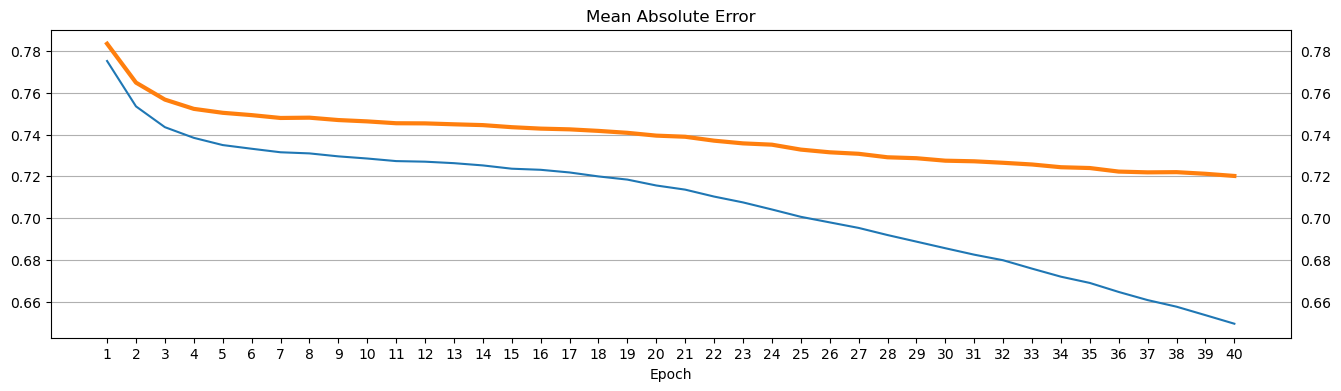

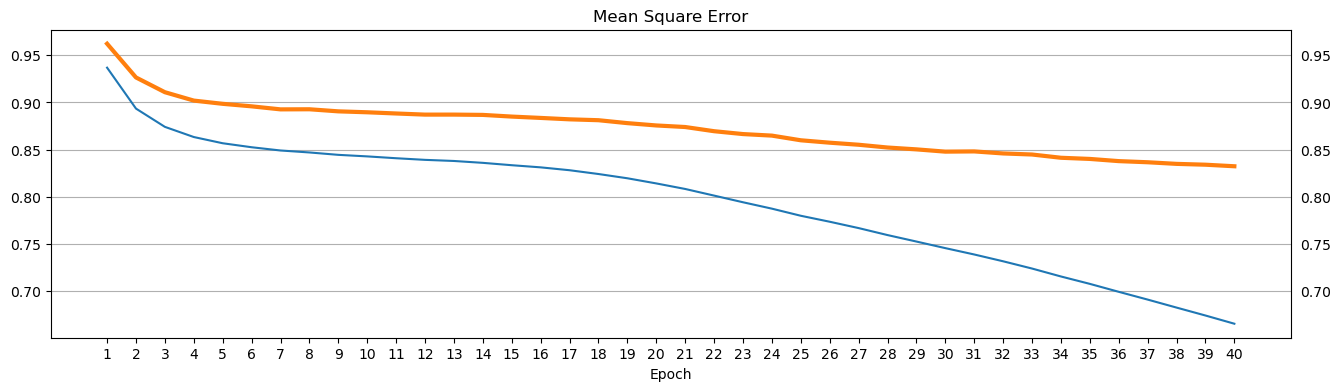

In [44]:
movielens.train(embSize=50, lr=0.01, wd=0.1, epochs=40, train_perc=0.8)

# Datios Intelia

Se pueden realizar pruebas con cualquier compañía pero me gustaría empezar por la 23 y 15.

In [11]:
!ls data

customers.csv  products.csv  relation.csv


In [19]:
dataPath = "data/"

df_intelia_users = pd.read_csv(dataPath + "customers.csv")
df_intelia_items = pd.read_csv(dataPath + "products.csv")
df_intelia_pairs = pd.read_csv(dataPath + "relation.csv")

/tmp/ipykernel_583/1378237331.py:3: DtypeWarning: Columns (7,9,10,11,12,13,17,18,21,26,27,28,30,36) have mixed types. Specify dtype option on import or set low_memory=False.
  df_intelia_users = pd.read_csv(dataPath + "customers.csv")
/tmp/ipykernel_583/1378237331.py:4: DtypeWarning: Columns (20,32,34,39) have mixed types. Specify dtype option on import or set low_memory=False.
  df_intelia_items = pd.read_csv(dataPath + "products.csv")


In [27]:
df_intelia_pairs["peso_logNat"] = np.log(df_intelia_pairs.peso + 1)
df_intelia_pairs["peso_logB2"]  = np.log2(df_intelia_pairs.peso + 1)
df_intelia_pairs["peso_logB10"] = np.log10(df_intelia_pairs.peso + 1)

## No hay duplicados

In [20]:
df_intelia_pairs [ df_intelia_pairs[["company_id", "product_id", "customer_id"]].duplicated() ]

,company_id,product_id,customer_id,peso,ultimo


In [21]:
df_intelia_pairs [ df_intelia_pairs[["product_id", "customer_id"]].duplicated() ]

,company_id,product_id,customer_id,peso,ultimo


# Compañias

In [22]:
company_ids = df_intelia_pairs.company_id.unique() #.tolist()
company_ids

array([ 1,  3,  4,  5,  6,  7,  8,  9, 10, 12, 13, 14, 15, 16, 18, 19, 21,
       23, 24, 29, 30, 31, 32, 33, 34, 35, 36, 39, 40, 44])

In [23]:
def get_dfs_company(comp_id):
    return df_intelia_pairs[ df_intelia_pairs.company_id == comp_id], \
           df_intelia_users[ df_intelia_users.company_id == comp_id], \
           df_intelia_items[ df_intelia_items.company_id == comp_id]

# Compañia 1

Number of users: 314
Number of items: 296
Number of interactions: 14902


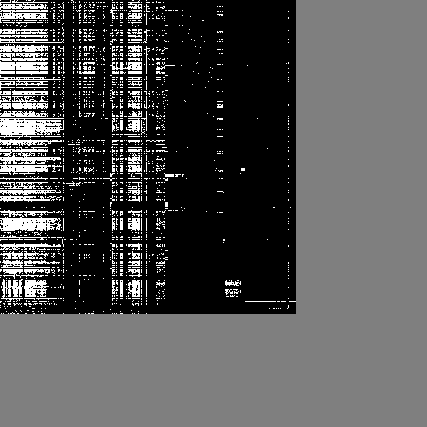

In [33]:
rs1 = RecSys(*get_dfs_company(1), varUser="customer_id", varItem="product_id", varScore="peso_logNat")
rs1.draw_matrix()

## Train with fast.ai

In [30]:
dls = CollabDataLoaders.from_df(ratings=get_dfs_company(1)[0],
                                valid_pct=0.2,
                                user_name="customer_id",
                                item_name="product_id",
                                rating_name="peso_logNat",
                                seed=None,
                                bs=64)
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5), metrics=[mae])
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,mae,time
0,1.276232,0.757377,0.670435,00:00
1,0.540055,0.492611,0.525336,00:00
2,0.449521,0.435794,0.491706,00:00
3,0.384841,0.420299,0.484427,00:00
4,0.332034,0.418090,0.482905,00:00


## Train with my module

Epoch: 1 ; trMAE = 0.6166 trMSE = 0.6350 valMAE = 0.6393 valMSE = 0.6819
Epoch: 2 ; trMAE = 0.5705 trMSE = 0.5451 valMAE = 0.6006 valMSE = 0.5991
Epoch: 3 ; trMAE = 0.5249 trMSE = 0.4632 valMAE = 0.5597 valMSE = 0.5312
Epoch: 4 ; trMAE = 0.4911 trMSE = 0.4029 valMAE = 0.5337 valMSE = 0.4822
Epoch: 5 ; trMAE = 0.4775 trMSE = 0.3776 valMAE = 0.5284 valMSE = 0.4702
Epoch: 6 ; trMAE = 0.4668 trMSE = 0.3619 valMAE = 0.5201 valMSE = 0.4560
Epoch: 7 ; trMAE = 0.4552 trMSE = 0.3429 valMAE = 0.5089 valMSE = 0.4413
Epoch: 8 ; trMAE = 0.4479 trMSE = 0.3304 valMAE = 0.5084 valMSE = 0.4428
Epoch: 9 ; trMAE = 0.4379 trMSE = 0.3166 valMAE = 0.4966 valMSE = 0.4271
Epoch: 10 ; trMAE = 0.4355 trMSE = 0.3091 valMAE = 0.4977 valMSE = 0.4266
Epoch: 11 ; trMAE = 0.4238 trMSE = 0.2962 valMAE = 0.4899 valMSE = 0.4189
Epoch: 12 ; trMAE = 0.4203 trMSE = 0.2908 valMAE = 0.4913 valMSE = 0.4209
Epoch: 13 ; trMAE = 0.4162 trMSE = 0.2837 valMAE = 0.4949 valMSE = 0.4229
Epoch: 14 ; trMAE = 0.4093 trMSE = 0.2748 valMA

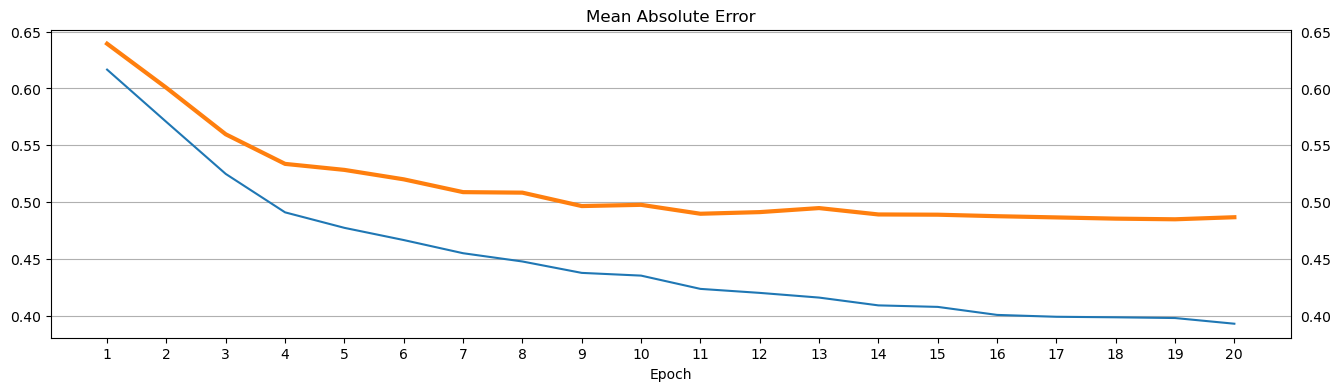

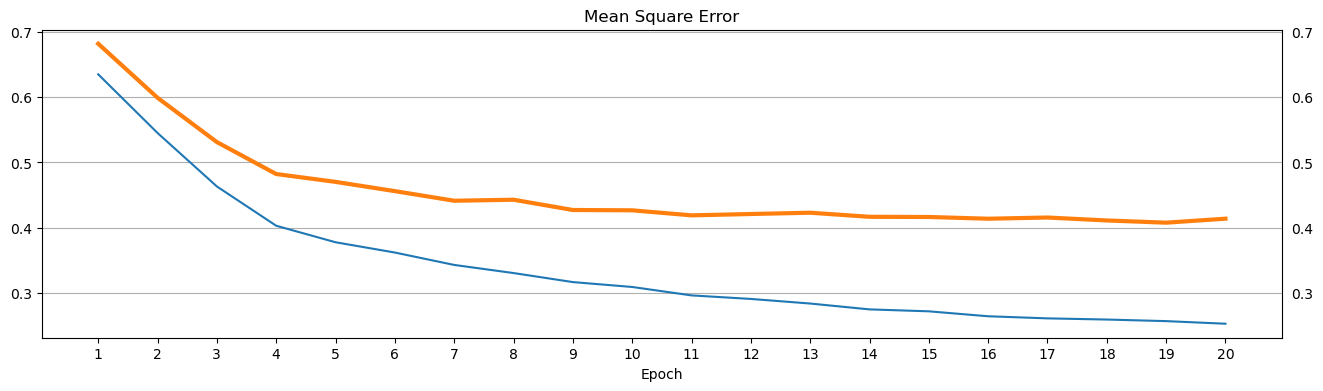

In [41]:
rs1.train(embSize=50, lr=5e-2, wd=0.1, epochs=20, train_perc=0.8)

# Otras compañias



COMPAÑÍA: 1
Number of users: 314
Number of items: 296
Number of interactions: 14902


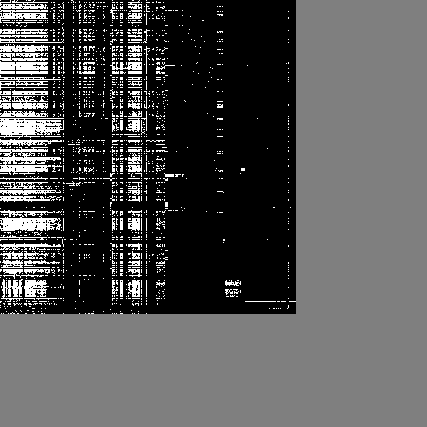



COMPAÑÍA: 3
Number of users: 384
Number of items: 65
Number of interactions: 847


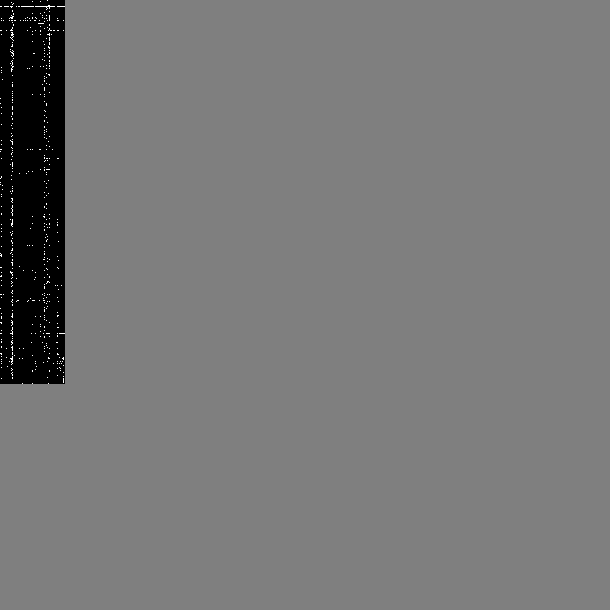



COMPAÑÍA: 4
Number of users: 2
Number of items: 3
Number of interactions: 5




COMPAÑÍA: 5
Number of users: 21
Number of items: 111
Number of interactions: 419


IndexError: index 50 is out of bounds for axis 1 with size 50

In [53]:
for comp_id in [1,3,4,5,6,7,8,9,10,12,18,19,29,30,31,32,34,35,44]:
    print("\n\nCOMPAÑÍA:", comp_id)
    rs = RecSys(*get_dfs_company(comp_id))
    rs.draw_matrix()

Compañia 1 ============================
Number of active users (eje y): 314 of 427 ( 73.54 %)
Number of active items (eje x): 296 of 504 ( 58.73 %)
Number of interactions (puntos blancos): 14902
	 - Blanco sobre negro 16.033 %
	 - Blanco sobre negro+gris 6.924 %


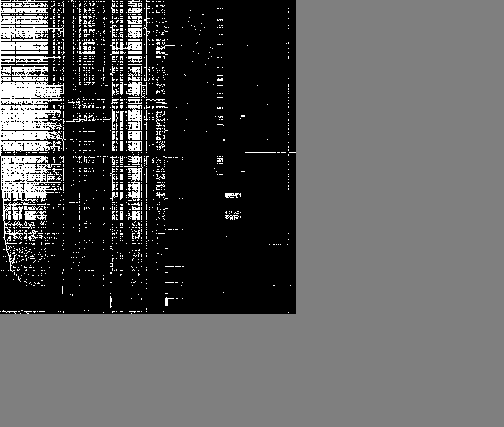

Compañia 3 ============================
Number of active users (eje y): 384 of 610 ( 62.95 %)
Number of active items (eje x): 65 of 78 ( 83.33 %)
Number of interactions (puntos blancos): 847
	 - Blanco sobre negro 3.393 %
	 - Blanco sobre negro+gris 1.78 %


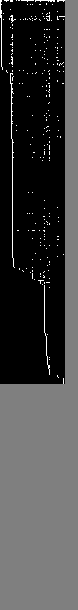

Compañia 4 ============================
Number of active users (eje y): 2 of 3 ( 66.67 %)
Number of active items (eje x): 3 of 124 ( 2.42 %)
Number of interactions (puntos blancos): 5
	 - Blanco sobre negro 83.333 %
	 - Blanco sobre negro+gris 1.344 %


Compañia 5 ============================
Number of active users (eje y): 21 of 50 ( 42.0 %)
Number of active items (eje x): 111 of 206 ( 53.88 %)
Number of interactions (puntos blancos): 419
	 - Blanco sobre negro 17.975 %
	 - Blanco sobre negro+gris 4.068 %


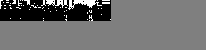

Compañia 6 ============================
Number of active users (eje y): 244 of 315 ( 77.46 %)
Number of active items (eje x): 749 of 3464 ( 21.62 %)
Number of interactions (puntos blancos): 4990
	 - Blanco sobre negro 2.73 %
	 - Blanco sobre negro+gris 0.457 %


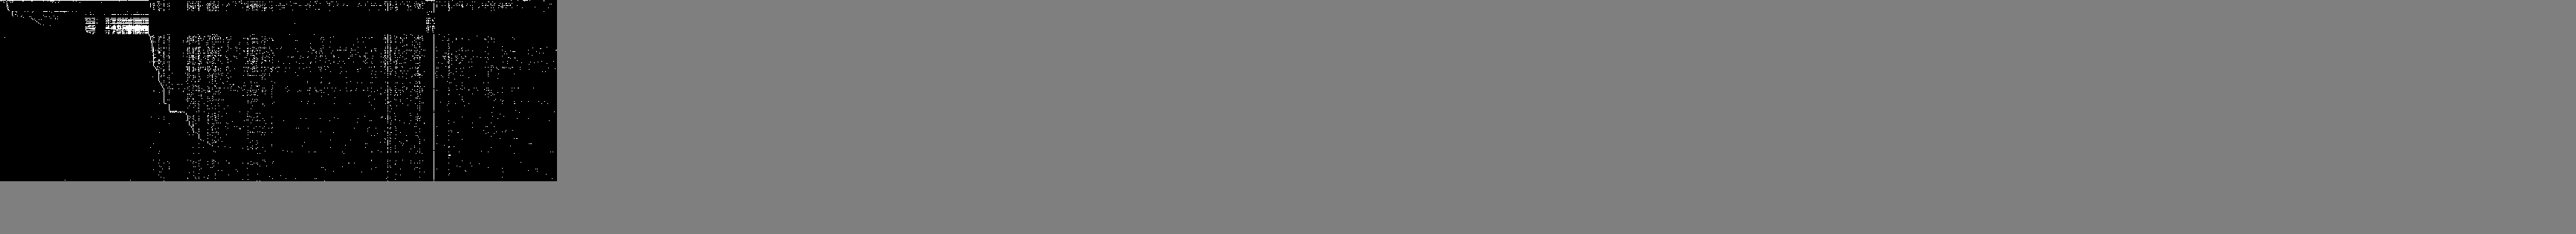

Compañia 7 ============================
Number of active users (eje y): 6 of 56 ( 10.71 %)
Number of active items (eje x): 34 of 96 ( 35.42 %)
Number of interactions (puntos blancos): 41
	 - Blanco sobre negro 20.098 %
	 - Blanco sobre negro+gris 0.763 %


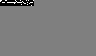

Compañia 8 ============================
Number of active users (eje y): 5 of 9 ( 55.56 %)
Number of active items (eje x): 21 of 104 ( 20.19 %)
Number of interactions (puntos blancos): 25
	 - Blanco sobre negro 23.81 %
	 - Blanco sobre negro+gris 2.671 %


Compañia 9 ============================
Number of active users (eje y): 8 of 16 ( 50.0 %)
Number of active items (eje x): 93 of 832 ( 11.18 %)
Number of interactions (puntos blancos): 111
	 - Blanco sobre negro 14.919 %
	 - Blanco sobre negro+gris 0.834 %


Compañia 10 ============================
Number of active users (eje y): 102 of 272 ( 37.5 %)
Number of active items (eje x): 111 of 265 ( 41.89 %)
Number of interactions (puntos blancos): 541
	 - Blanco sobre negro 4.778 %
	 - Blanco sobre negro+gris 0.751 %


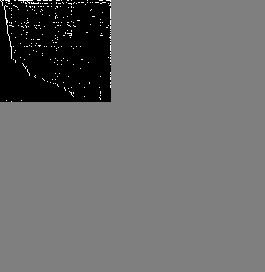

Compañia 12 ============================
Number of active users (eje y): 166 of 695 ( 23.88 %)
Number of active items (eje x): 1218 of 20152 ( 6.04 %)
Number of interactions (puntos blancos): 1784
	 - Blanco sobre negro 0.882 %
	 - Blanco sobre negro+gris 0.013 %


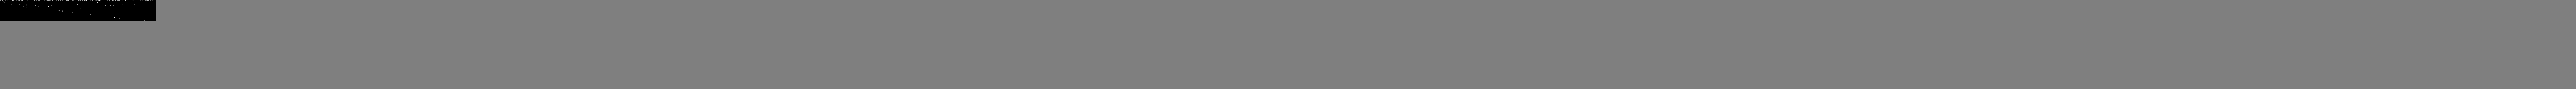

Compañia 18 ============================
Number of active users (eje y): 2 of 16 ( 12.5 %)
Number of active items (eje x): 2 of 2 ( 100.0 %)
Number of interactions (puntos blancos): 2
	 - Blanco sobre negro 50.0 %
	 - Blanco sobre negro+gris 6.25 %


Compañia 19 ============================
Number of active users (eje y): 5 of 7 ( 71.43 %)
Number of active items (eje x): 32 of 184 ( 17.39 %)
Number of interactions (puntos blancos): 42
	 - Blanco sobre negro 26.25 %
	 - Blanco sobre negro+gris 3.261 %


Compañia 29 ============================
Number of active users (eje y): 467 of 606 ( 77.06 %)
Number of active items (eje x): 39 of 39 ( 100.0 %)
Number of interactions (puntos blancos): 663
	 - Blanco sobre negro 3.64 %
	 - Blanco sobre negro+gris 2.805 %


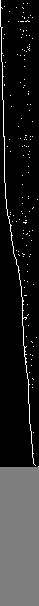

Compañia 30 ============================
Number of active users (eje y): 1 of 363 ( 0.28 %)
Number of active items (eje x): 30 of 31 ( 96.77 %)
Number of interactions (puntos blancos): 30
	 - Blanco sobre negro 100.0 %
	 - Blanco sobre negro+gris 0.267 %


Compañia 31 ============================
Number of active users (eje y): 86 of 342 ( 25.15 %)
Number of active items (eje x): 23 of 25 ( 92.0 %)
Number of interactions (puntos blancos): 201
	 - Blanco sobre negro 10.162 %
	 - Blanco sobre negro+gris 2.351 %


Compañia 32 ============================
Number of active users (eje y): 29 of 292 ( 9.93 %)
Number of active items (eje x): 18 of 18 ( 100.0 %)
Number of interactions (puntos blancos): 103
	 - Blanco sobre negro 19.732 %
	 - Blanco sobre negro+gris 1.96 %


Compañia 34 ============================
Number of active users (eje y): 8 of 46 ( 17.39 %)
Number of active items (eje x): 13 of 105 ( 12.38 %)
Number of interactions (puntos blancos): 14
	 - Blanco sobre negro 13.462 %
	 - Blanco sobre negro+gris 0.29 %


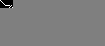

Compañia 35 ============================
Number of active users (eje y): 44 of 330 ( 13.33 %)
Number of active items (eje x): 50 of 58 ( 86.21 %)
Number of interactions (puntos blancos): 260
	 - Blanco sobre negro 11.818 %
	 - Blanco sobre negro+gris 1.358 %


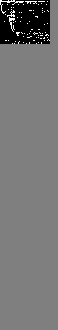

Compañia 44 ============================
Number of active users (eje y): 1 of 2 ( 50.0 %)
Number of active items (eje x): 4 of 6 ( 66.67 %)
Number of interactions (puntos blancos): 4
	 - Blanco sobre negro 100.0 %
	 - Blanco sobre negro+gris 33.333 %


In [26]:
for comp_id in [1,3,4,5,6,7,8,9,10,12,18,19,29,30,31,32,34,35,44]:
    explore_company( comp_id )

# Compañia 4

In [45]:
rs = RecSys(*get_dfs_company(4))
rs.draw_matrix()

Number of users: 2
Number of items: 3
Number of interactions: 5


In [21]:
#explore_company( 23 )

In [27]:
def seePeso(pd_series):
    print("Min:", pd_series.min(), "Max:", pd_series.max(), "Mean:", pd_series.mean(), "Mode:", pd_series.mode()[0])
    pd_series.plot.hist(bins=200, figsize=(12,3))

Min: 0.02 Max: 13248.0 Mean: 5.739287019276839 Mode: 3.0


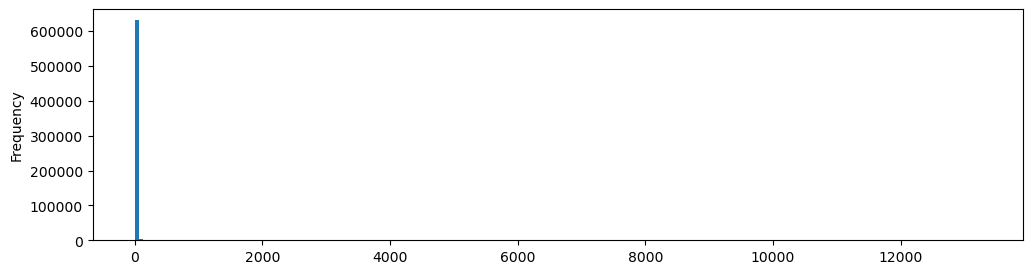

In [28]:
seePeso(df_relation.peso)

Min: 0.01980262729617973 Max: 9.491677356868124 Mean: 1.3854070950859176 Mode: 1.3862943611198906


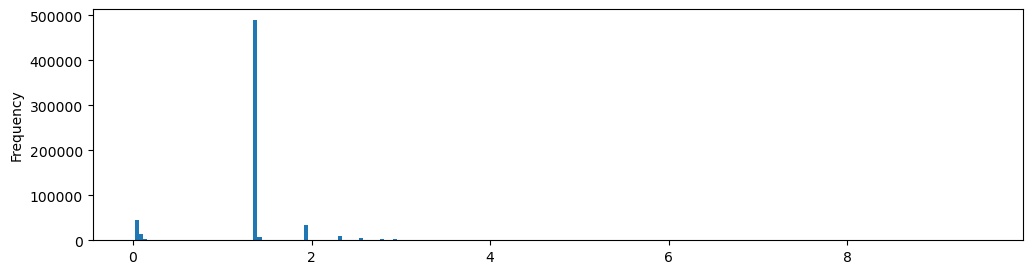

In [30]:
seePeso(df_relation.peso_logNat)

Min: 0.02856915219677092 Max: 13.693595852471706 Mean: 1.998719945692838 Mode: 2.0


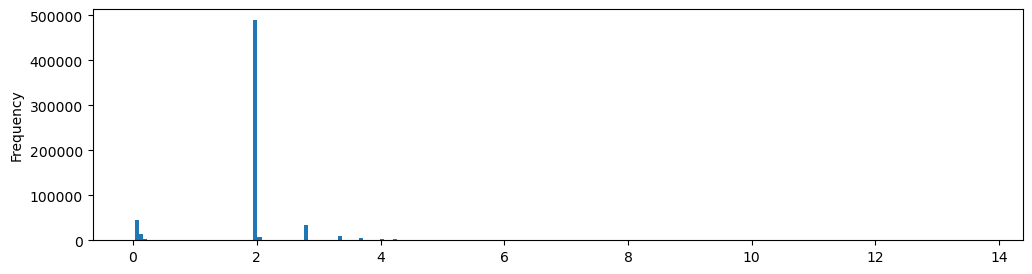

In [31]:
seePeso(df_relation.peso_logB2)

Min: 0.008600171761917567 Max: 4.122183100093868 Mean: 0.6016746565854277 Mode: 0.6020599913279624


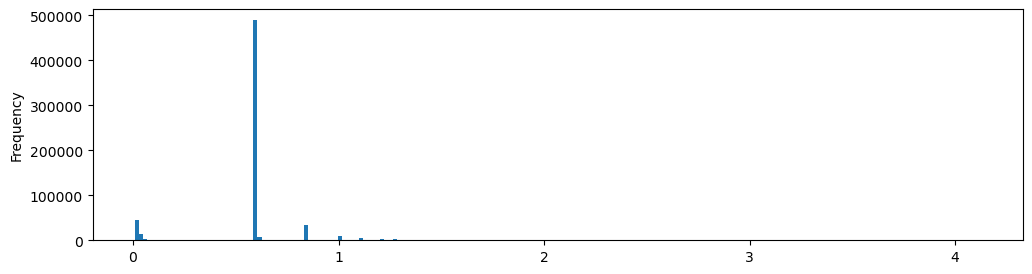

In [32]:
seePeso(df_relation.peso_logB10)

In [23]:
df_comp1_relation = df_relation[ df_relation.company_id==1 ]
df_comp23_relation = df_relation[ df_relation.company_id==23 ]
df_comp23_relation

,company_id,product_id,customer_id,peso,ultimo,peso_logNat,peso_logB2,peso_logB10
146424,23,28888,118364,0.08,2022-08-12 20:15:34,0.076961,0.111031,0.033424
146425,23,28890,532280,0.08,2022-08-12 20:08:26,0.076961,0.111031,0.033424
146426,23,28891,101041,0.08,2022-08-12 19:06:38,0.076961,0.111031,0.033424
146427,23,28892,116295,0.08,2022-08-12 11:14:09,0.076961,0.111031,0.033424
146428,23,28893,117588,0.08,2022-08-13 04:15:28,0.076961,0.111031,0.033424
...,...,...,...,...,...,...,...,...
636512,23,57621,537317,0.04,2022-01-14 10:09:18,0.039221,0.056584,0.017033
636513,23,57739,537317,0.04,2022-01-14 10:09:08,0.039221,0.056584,0.017033
636514,23,58193,111111,0.04,2022-10-02 23:16:52,0.039221,0.056584,0.017033
636515,23,58743,537565,0.04,2022-08-26 19:25:13,0.039221,0.056584,0.017033


In [20]:
dls = CollabDataLoaders.from_df(ratings=df_comp23_relation,
                                valid_pct=0.2,
                                user_name="customer_id",
                                item_name="product_id",
                                rating_name="peso_boxcox",
                                seed=None,
                                bs=64)

In [21]:
dls.show_batch()

,customer_id,product_id,peso_boxcox
0,103678,52095,1.217070
1,106182,52128,1.217070
2,102466,54429,-2.431309
3,119814,55365,1.217070
4,101704,51626,1.217070
5,104603,54587,3.163362
6,109085,51529,1.288723
7,104647,51473,1.217070
8,102744,50469,1.217070
9,112106,55206,1.217070


In [22]:
learn = collab_learner(dls, n_factors=50, y_range=(-3, 26), metrics=[mae])
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,mae,time
0,32.867165,29.344473,4.384726,00:04
1,9.773914,11.014664,2.173610,00:04
2,5.756277,9.591437,1.962001,00:04
3,3.518925,9.243389,1.878011,00:04
4,2.503077,9.206673,1.863185,00:04


In [28]:
learn = collab_learner(dls, n_factors=50, y_range=(-3, 26), metrics=[mae])
learn.fit_one_cycle(5, lr_max=5e-3, wd=0.1)

epoch,train_loss,valid_loss,mae,time
0,31.172041,28.926107,4.342701,00:04
1,9.897020,10.968962,2.173523,00:04
2,5.556270,9.571959,1.960996,00:04
3,3.596327,9.269145,1.884384,00:04
4,2.608569,9.222979,1.863855,00:04


In [34]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(17393, 50)
  (i_weight): Embedding(5989, 50)
  (u_bias): Embedding(17393, 1)
  (i_bias): Embedding(5989, 1)
)

In [35]:
learn.model.u_weight

Embedding(17393, 50)

In [36]:
learn.model.u_weight.weight

Parameter containing:
tensor([[-0.0016,  0.0037,  0.0010,  ..., -0.0008,  0.0040, -0.0041],
        [-0.0716, -0.0509, -0.0683,  ..., -0.0347,  0.0673, -0.0733],
        [-0.0760, -0.0918, -0.0785,  ..., -0.0951,  0.0828, -0.0619],
        ...,
        [-0.0818, -0.0723, -0.0730,  ..., -0.0711,  0.0745,  0.0753],
        [-0.0226, -0.0100, -0.0013,  ..., -0.0036,  0.0172,  0.0155],
        [-0.0749, -0.0751, -0.0781,  ..., -0.0733,  0.0790,  0.0556]],
       device='cuda:0', requires_grad=True)

In [48]:
0.91**2

0.8281000000000001